# ЗАДАЧА КРЕДИТНОГО СКОРИНГА

Описание полей

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту [target binar]

# Импорт библиотек

In [1]:
import os
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Загрузка данных

In [2]:
#train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
#test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
#sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
# Объединяем тренировочные и тестовые данные в один датасет.
train['train'] = 1  # помечаем тренировочные
test['train'] = 0  # помечаем тестовые
data = pd.concat([train, test], ignore_index=True)
data.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
97548,83315,31MAR2014,UGR,M,35,N,N,3,0,-1.310632,3,50,2,3,38000,1,4,N,NaN,0
51923,46973,24FEB2014,GRD,F,50,Y,Y,0,1,-1.467035,1,80,2,3,130000,2,3,N,0.0,1
3977,55210,04MAR2014,GRD,F,28,Y,N,0,0,-1.875006,3,50,1,2,300000,1,2,N,0.0,1
22043,1564,06JAN2014,SCH,M,43,N,N,0,0,-1.779482,1,70,1,2,30000,4,1,N,0.0,1
96922,90686,07APR2014,GRD,F,25,N,N,2,0,-1.467671,2,50,2,3,20000,1,3,N,NaN,0
85466,86932,03APR2014,SCH,F,62,Y,N,0,0,-2.314384,0,50,2,3,8500,1,4,N,NaN,0
43960,48761,25FEB2014,SCH,M,42,N,N,0,0,-2.706620,0,50,1,3,15000,3,1,Y,0.0,1
33094,99463,16APR2014,SCH,F,42,N,N,0,0,-1.848043,1,70,2,3,15000,4,1,N,0.0,1
7853,27063,03FEB2014,SCH,F,37,N,N,0,0,-1.774584,6,40,2,3,23000,1,3,N,1.0,1
8584,17658,24JAN2014,GRD,F,25,N,N,0,0,-0.867219,5,60,1,2,5000,4,1,N,0.0,1


# Первоначальная информация о датасете

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [5]:
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [6]:
data.isnull().sum(axis=0)

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

# EDA

# 1. Удаляем нули

In [7]:
display(data['education'].value_counts(dropna=False))

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [8]:
# заменим самым нули самым популярным значением
data['education'].fillna('SCH', inplace=True)

# 2. Группировка данных

In [9]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'train'],
      dtype='object')

In [10]:
# добавим три группы

# числовой
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'score_bki', 'region_rating']

# категории
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']

# бинарный
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# 3. Иследование числовых признаков

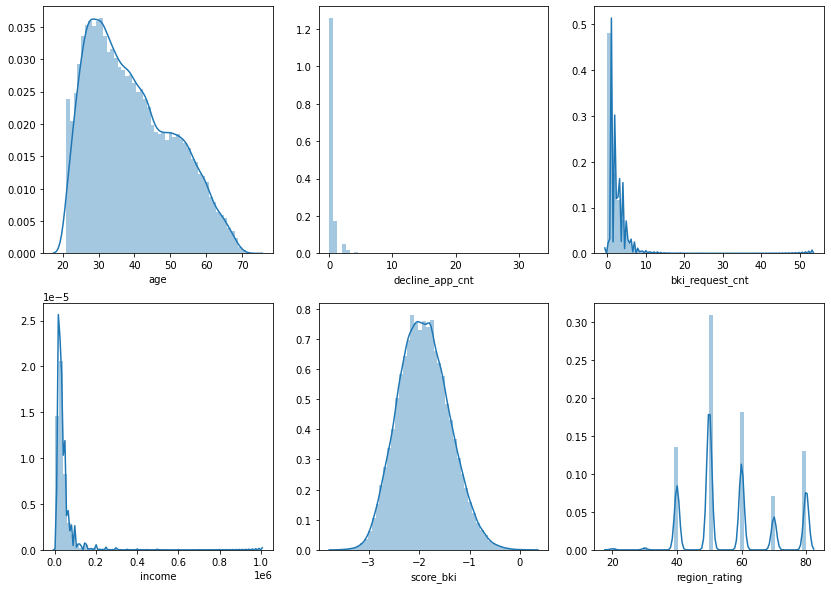

In [11]:
# take a look on dist of numerical data
a, b, c = 2, 3, 1  # c stands for counter and a&b for subplots params
fig = plt.figure(figsize=(14, 10))
for col in num_cols:
    plt.subplot(a, b, c)
    plt.xlabel(col)
    sns.distplot(data[col])
    c = c + 1

plt.show()

Что мы видим:
* некоторые числовые фичи имеют сильный правый хвост, нужно будет логарифмировать их
* score_bki уже выглядит как нормальное распределение

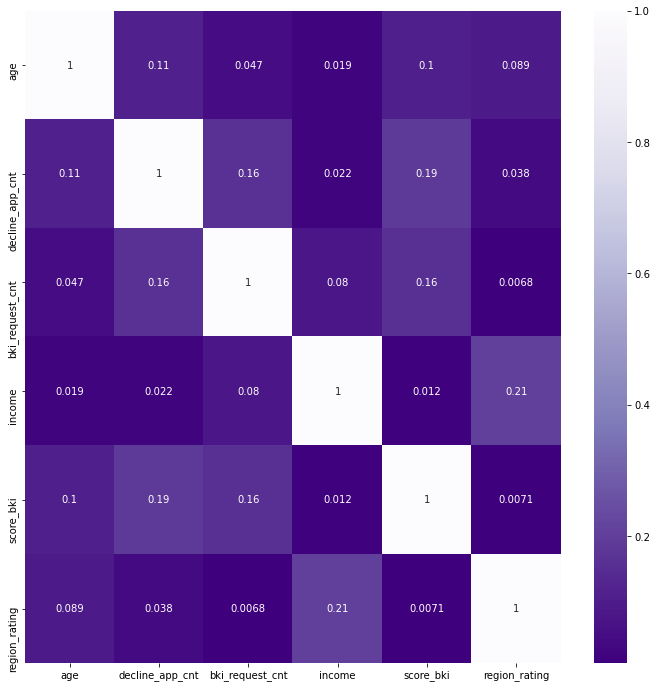

In [12]:
# check heatmap for too strong correlations as we building linear model
plt.figure(figsize=(12, 12))
sns.heatmap(data[num_cols].corr().abs(), annot=True, cmap='Purples_r')
plt.show()

Видим слабую корреляцию между признаками

# 4. Иследование бинарных и категориальных признаков

In [13]:
# Используем LabelEncoder для отображения каждого значения категории в уникальное число

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [14]:
# посмотрим на результат
data.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1


In [15]:
# преобразуем education в числовой вид
data['education'] = data['education'].astype('category').cat.reorder_categories(
    ['SCH', 'GRD', 'UGR', 'PGR', 'ACD']).cat.codes

In [16]:
# посмотрим на результат
data.head(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,0,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1
1,63161,12MAR2014,0,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1
2,25887,01FEB2014,0,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1
3,16222,23JAN2014,0,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1
4,101655,18APR2014,1,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1
5,41415,18FEB2014,0,1,27,1,0,0,1,-2.032257,0,50,1,1,15000,2,3,0,0.0,1
6,28436,04FEB2014,0,1,39,0,0,0,0,-2.225004,0,60,1,2,28000,1,1,0,0.0,1
7,68769,17MAR2014,0,0,39,0,0,0,0,-1.522739,1,50,2,3,45000,3,3,0,0.0,1
8,38424,14FEB2014,0,0,50,1,0,1,0,-1.676061,0,50,1,1,30000,1,4,0,0.0,1
9,4496,10JAN2014,2,0,54,0,0,0,0,-2.695176,1,50,2,3,24000,1,3,0,0.0,1


# 5. Колонка 'app_date'

In [17]:
# конвертируем в тип datetime
data['app_date'] = pd.to_datetime(data['app_date'])

In [18]:
# посмотрим года
display(data['app_date'].dt.year.value_counts())

2014    110148
Name: app_date, dtype: int64

In [19]:
# посмотрим месяцы
display(data['app_date'].dt.month.value_counts())

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

Мы имеем только первые 4 месяца 2014 года

# 6. Добавление фич

In [20]:
# добавим колонку с месяцем
data['month'] = data['app_date'].dt.month

# обновим категориальную группу
cat_cols.append('month')

In [21]:
data['decline_app_cnt'].value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

In [22]:
# сделаем из колонки decline_app_cnt категориальный признак
data['decline_app_cnt'] = data['decline_app_cnt'].apply(
    lambda x: x if x < 4 else 4)

# обновим группы
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

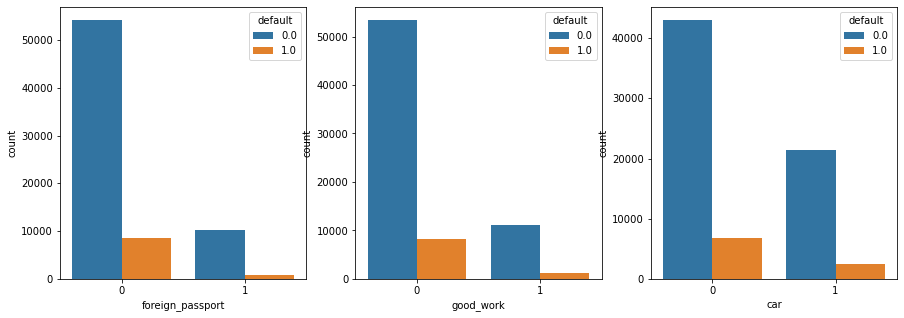

In [23]:
# мы можем помочь нашей модели выявлять достойных клиентов, объединив эти фичи

signs_of_decency = ['foreign_passport', 'good_work', 'car']

a, b, c = 1, 3, 1
fig = plt.figure(figsize=(15, 5))
for col in signs_of_decency:
    plt.subplot(a, b, c)
    plt.xlabel(col)
    sns.countplot(data=data, hue='default', x=col)
    c = c + 1

plt.show()

Как мы видим, эти три признака сильно влияют на целевую переменную. Попробуем объединить их.

In [24]:
data['decent_customer_rate'] = (
    data['foreign_passport'] + 1) * (data['good_work'] + 1) * (data['car'] + 1)

In [25]:
# обновим группу
cat_cols.append('decent_customer_rate')

In [26]:
# логарифмируем "хвостатые" признаки

num_cols_tailed = ['age', 'bki_request_cnt', 'income']

for col in num_cols_tailed:
    data[col] = np.log(data[col] + 1)


for col in num_cols_tailed:
    data[col] = np.log(data[col] + 1)

In [27]:
#добавим полиноминальные признаки
pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(data[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
data = data.join(poly_df, how='left')

In [28]:
# разделим наши данные
train = data.query('train == 1').drop(['train'], axis=1)
test = data.query('train == 0').drop(['train'], axis=1)

# 7. Анализ важности признаков

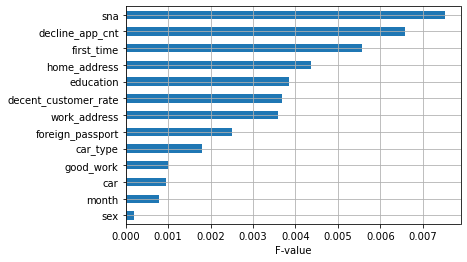

In [29]:
# построим F - values по категориальным и бинарным признакам
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', grid=True)
plt.xlabel('F-value')
plt.show()

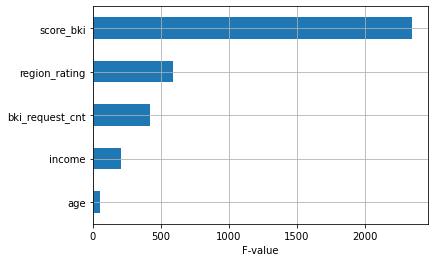

In [30]:
# тоже самое для числовых признаков
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', grid=True)
plt.xlabel('F-value')
plt.show()

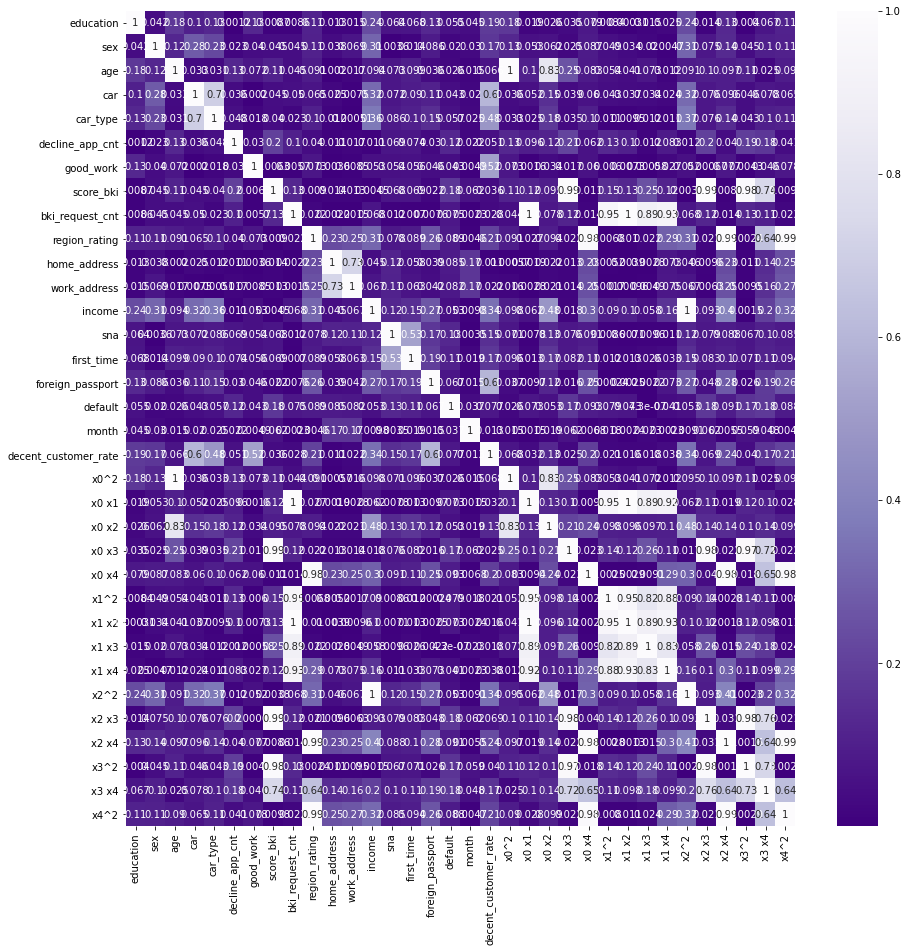

In [31]:
plt.figure(figsize=(15, 15))
sns.heatmap(train.drop(['client_id'], axis=1).corr(
).abs(), annot=True, cmap='Purples_r')

# 8. Построение модели

In [32]:
# dummy переменные для категориальных признаков
X_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
X_cat

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [33]:
Y_cat = OneHotEncoder(sparse=False).fit_transform(test[cat_cols].values)
Y_cat

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [34]:
# стандартизируем числовые тренеровочные переменные
X_num = StandardScaler().fit_transform(train[num_cols].values)
X_num

array([[ 1.65533216, -0.09524766, -0.77798224, -0.2087987 , -0.51515718],
       [ 1.4999249 ,  0.81111707, -0.6963564 ,  0.74754461, -0.51515718],
       [-1.4235564 , -0.09524766, -0.02257578,  0.99669566,  1.78270228],
       ...,
       [-0.64728574,  1.04723006,  0.55312826,  0.78696739,  1.78270228],
       [-0.88463179,  0.81111707, -1.27807247,  0.85380611, -0.51515718],
       [-0.32335567,  0.47180311, -0.28820487,  0.28102087, -0.51515718]])

In [35]:
# стандартизируем числовые тестовые переменные

Y_num = StandardScaler().fit_transform(test[num_cols].values)
Y_num

array([[-0.87639712,  0.80739222,  0.70236174, -0.73288746, -0.51984533],
       [ 0.15606297,  0.46857465, -2.85246466,  0.79551047, -0.51984533],
       [ 0.97978082, -0.09764656, -0.02250624,  0.42413578, -0.51984533],
       ...,
       [-0.63902145, -0.09764656,  0.95351663,  1.92005304, -0.51984533],
       [-1.13403681,  0.46857465, -0.02250624,  1.31888606,  1.77259941],
       [ 0.06777833,  0.46857465, -1.06025513,  0.79042787, -0.51984533]])

In [36]:
# объединяем

X = np.hstack([X_num, train[bin_cols].values, train[poly_cols].values, X_cat])
Y = train['default'].values
id_test = test['client_id']

In [37]:
# разделяем на тренеровочные и валидационные данные
X_train, X_valid, y_train, y_valid = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True)

In [38]:
# Подбор лучших гиперпараметров для модели

from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 59.94842503189409


In [39]:
# описываем и обучаем модель
model = LogisticRegression(
    C=59.94842503189409,
    class_weight='balanced',
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    multi_class='auto',
    n_jobs=None,
    penalty='l2',
    solver='liblinear',
    verbose=0,
    max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=59.94842503189409, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [40]:
# предсказываем значения валидационной базы
Y_predict = model.predict(X_valid)
Y_predict_prob = model.predict_proba(X_valid)[:, 1]

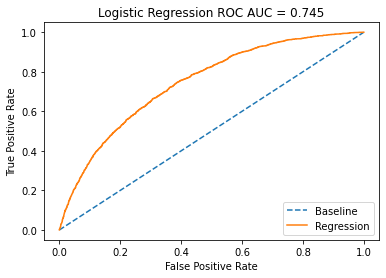

In [41]:
# строим ROC-кривую
fpr, tpr, threshold = roc_curve(y_valid, Y_predict_prob)
roc_auc = roc_auc_score(y_valid, Y_predict_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [46]:
#данные для kaggle
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)
X_test = np.hstack([X_num_test, test[bin_cols].values, test[poly_cols].values, X_cat_test])

y_probs = model.predict_proba(X_test)[:,1]

test['default'] = y_probs
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

submission.to_csv('submission.csv', index=False)

,client_id,default
93658,86726,0.118014
108105,103758,0.485414
86525,45470,0.271640
81314,76716,0.259028
96379,24172,0.574226
93705,73019,0.612530
101926,25202,0.369151
97856,76002,0.446070
78106,35556,0.380779
73799,74835,0.242860


(36349, 2)